In [1]:
from datetime import datetime
import pickle
import PIL, torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import ndimage

from torchvision import models
from torch import nn
import pandas as pd

from load_data import load_et_maps, load_images, load_labels, classes
from load_models import load_mobilenet, load_resnet
from utils import batch_accuracy, get_targets

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)
dtype = torch.float32

OCC_ONLY = Path('/home/florian/dev/ET-Adversarials/data/Occ_only_226px/')
IMGS = Path('/home/florian/dev/ET-Adversarials/data/scaled_images/')

#torch.cuda.set_per_process_memory_fraction(.5,0)

cuda:0


# Load Data and Model

In [4]:
img_batch = load_images(IMGS).to(device)
etm_batch = load_et_maps(OCC_ONLY).to(device)
labels = load_labels(IMGS).to(device)

In [2]:
MOBILENET_PATH = './models/MobileNetV3Small.pt'
#MOBILENET_PATH = './MobileNetV3Small.pt'
model = load_mobilenet(MOBILENET_PATH).to(device)
#batch_accuracy(model, img_batch, labels)

/home/florian/anaconda2/envs/PT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/florian/anaconda2/envs/PT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
a = model(img_batch).argmax(axis=-1).cpu()
np.where(a==1)

(array([ 0,  3,  7, 17, 41, 45, 59, 63, 68, 71]),)

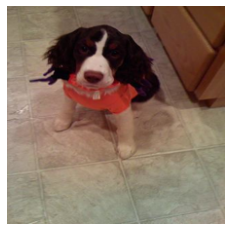

In [23]:
plt.imshow(img_batch[45].cpu().permute(1, 2, 0))
plt.axis('off')
plt.savefig('goofball.png', bbox_inches='tight')


# Step by Step Attack

We first create the GradCam Heatmap with the help of the pytorch GradCam Package

In [14]:
img_batch.shape

torch.Size([100, 3, 224, 224])

In [11]:
hm = cam(input_tensor=img_batch)

In [12]:
hm.shape

(100, 224, 224)

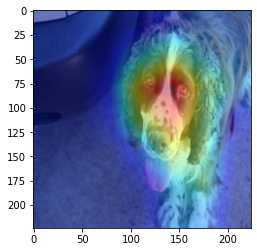

In [4]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

i=0

target_layers = [list(model.modules())[-9]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
img = img_batch[i].detach().cpu()
hm = cam(input_tensor=img_batch[i:i+1])


plt.imshow(img_batch[i].detach().cpu().permute(1,2,0))
plt.imshow(hm.transpose(1,2,0), cmap='jet', alpha=0.4)

In [32]:
model

Sequential(
  (0): ImageNetNormalization()
  (1): MobileNetV3(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (relu): ReLU(inplace=True)
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1),

In [29]:
model[1].features[-1][0]

Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)

From the GradCam the most important Pixels (e.g. only the top 15%)

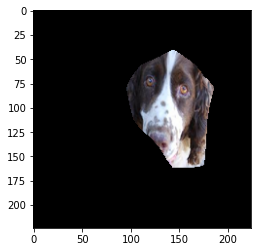

In [14]:
threshold = np.quantile(hm.flatten(), .85)
b_mask = np.where(hm>threshold, np.ones_like(hm), np.zeros_like(hm))

plt.imshow((b_mask*img_batch[0].detach().cpu().numpy()).transpose(1,2,0))


In [15]:
## delete this later
invariance_based_adv = torch.Tensor(
    np.where(
        b_mask==True, 
        img_batch[0].detach().cpu().numpy(), 
        img_batch[2].detach().cpu().numpy()
    )
)

calculate the center of mass of the mask

In [16]:
c_o_m = ndimage.measurements.center_of_mass(b_mask);c_o_m

(0.0, 99.5680882157566, 143.16713165935963)

now we find ourself a nice attack image and again create the gradcam heatmap

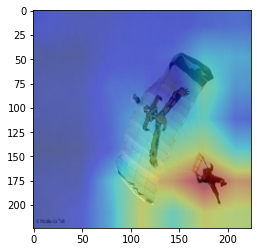

In [17]:
i = 12
a_img = img_batch[i:i+1].detach().cpu()
a_hm = cam(input_tensor=a_img)

plt.imshow(a_img[0].detach().cpu().permute(1,2,0))
plt.imshow(a_hm.transpose(1,2,0), cmap='jet', alpha=0.4)

Similar to our base image, we calculate a binary map with the x most important pixels

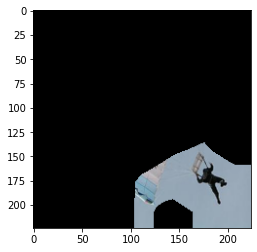

In [18]:
a_threshold = np.quantile(a_hm.flatten(), .85)
a_b_mask = np.where(a_hm>=a_threshold, np.ones_like(a_hm), np.zeros_like(a_hm))

plt.imshow((a_b_mask*a_img[0].detach().cpu().numpy()).transpose(1,2,0))

calculate the center of mass

In [19]:
a_c_o_m = ndimage.measurements.center_of_mass(a_b_mask); a_c_o_m

(0.0, 184.28736548425667, 168.16261458748505)

We now want to align the center of mass of the attack image with the center of mass of the base image, we therefore calculate the offset and subsequently pad and crop the attack image

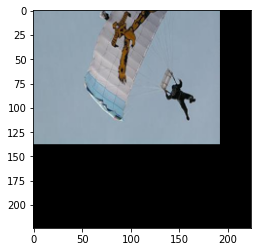

In [20]:
offset = np.array(c_o_m) - np.array(a_c_o_m);offset[1:]
img_to_copy = np.pad(a_img[0,:,86:,32:].numpy(), (((0,0),(0,86),(0,32))))
plt.imshow(img_to_copy.transpose(1,2,0))

now we create the adversarial example: we cover the most important parts of the base image with the most important parts of the attack image

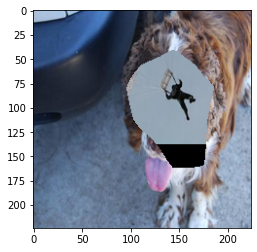

In [21]:
invariance_adv = np.where(b_mask==True, img_to_copy, img).transpose(1,2,0)

plt.imshow(invariance_adv)

Let's see what the model predicts

In [22]:
print('base image: class', model(img.unsqueeze(0).cuda()).argmax(-1).item())
print('attack image: class', model(a_img.cuda()).argmax(-1).item())
print('adversarial example: class',model(torch.Tensor(invariance_adv).permute(2,1,0).unsqueeze(0).cuda()).argmax(-1).item())

base image: class 1
attack image: class 9
adversarial example: class 1


We see that the adversarial example has still the same prediction as the base image. As such the first condition of an invariance based adversarial example is given. As a reminder invariance based adversarial examples are defined as images that (1) do not change the model's prediction and (2) humans assign the image an other class.

Programatically, we can only verify the first condition. So it is sensible to start with a small amount of pixel to change and increase the amount subsequently until the label is flipped, then go one step backwards and use the adversarial example with the highest amount of changed pixels that has the assigned label unchanged

# Function

In [49]:
def create_invariance_based_adversarial_example(base_image, attack_image, initial_ratio):
    '''
    base_image: 3d torch.Tensor
    attack_image: 3d torch.Tensor
    returns the invariance based adversarial example and a tensor with the predictions of the base image, the attack iamge and the adversarial example
    '''
    target_layers = [list(model.modules())[-9]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    
    img = base_image.detach().cpu()
    hm = cam(input_tensor=base_image.unsqueeze(0))
    attack_hm = cam(input_tensor=attack_image.unsqueeze(0))
    best_adv = np.array((224,224,3))
    #print(np.flip(np.arange(1,0,.01)))
    for ratio in np.flip(np.linspace(0,1,101)):
        #print(ratio)
        threshold = np.quantile(hm.flatten(), ratio)
        b_mask = np.where(hm>threshold, np.ones_like(hm), np.zeros_like(hm))
        base_c_o_m = ndimage.measurements.center_of_mass(b_mask)

        
        attack_threshold = np.quantile(attack_hm.flatten(), ratio)
        attack_b_mask = np.where(attack_hm>=attack_threshold, np.ones_like(a_hm), np.zeros_like(a_hm))
        attack_c_o_m = ndimage.measurements.center_of_mass(attack_b_mask)


        #to copy the important part of the attack image to the desired location in the base image, 
        #we calculate the offset of the center of mass of the respective binary maps derived from the gradcam map
        #we then pad and slice the attack image in such a way that the locations of interest in the base and attack images 
        #finally overlap
        _, offset_horizontal, offset_vertical = np.array(base_c_o_m) - np.array(attack_c_o_m)
        padding = np.array([
            np.maximum(offset_horizontal, 0), 
            np.maximum(offset_vertical,0), 
            np.abs(np.minimum(offset_horizontal, 0)), 
            np.abs(np.minimum(offset_vertical,0))
        ]).astype(np.int16)

        slicing = np.array([np.abs(np.minimum(offset_horizontal, 0)), np.abs(np.minimum(offset_vertical,0)), np.maximum(offset_horizontal, 0), np.maximum(offset_vertical,0)]).astype(np.int16)
        sliced_img = attack_image[:,slicing[0]:224-slicing[2], slicing[1]:224-slicing[3]]
        padded_img = np.pad(sliced_img.numpy(), ((0,0),(padding[0],padding[2]),(padding[1], padding[3])))
        invariance_adv = np.where(b_mask==True, padded_img, base_image).transpose(1,2,0)
        preds = model(torch.stack((base_image, attack_image,torch.Tensor(invariance_adv).permute(2,0,1) )).cuda()).argmax(-1)
        print(model(torch.stack((base_image, attack_image,torch.Tensor(invariance_adv).permute(2,0,1) )).cuda()).softmax(-1).max(-1))
        print(preds)
        if preds[0] != preds[2]:
            break
        else:
            best_adv = invariance_adv

    
    preds = model(torch.stack((base_image, attack_image,torch.Tensor(best_adv).permute(2,0,1) )).cuda()).argmax(-1)

    #print('*****--------*******')
    return best_adv, preds, (attack_hm, hm)

44
torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([8, 1, 8], device='cuda:0'))
tensor([8, 1, 8], device='cuda:0')
torch.return_types.max(
values=tensor([1.0000, 1.0000, 0.9965], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([8, 1, 8], device='cuda:0'))
tensor([8, 1, 8], device='cuda:0')
torch.return_types.max(
values=tensor([1.0000, 1.0000, 0.9633], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([8, 1, 8], device='cuda:0'))
tensor([8, 1, 8], device='cuda:0')
torch.return_types.max(
values=tensor([1.0000, 1.0000, 0.9212], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([8, 1, 8], device='cuda:0'))
tensor([8, 1, 8], device='cuda:0')
torch.return_types.max(
values=tensor([1.0000, 1.0000, 0.9342], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([8, 1, 8], device='cuda:0'))
tensor([8, 1, 8], device='cuda:0')
torch.return_types.max(
values=tensor([1.0000, 1.0000, 0.9707], device='

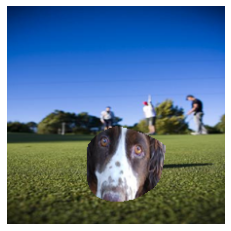

In [50]:
for i in range(44,45):
    base_image = img_batch[i].cpu()
    #fix, axes = plt.subplots(20,5, figsize=(20,200))
    Path('./inv-based-advs/base-'+str(i)).mkdir(parents=True, exist_ok=True)
    print(i)
    #for j,ax in enumerate(axes.flatten()):
    for j in range(1):
        attack_image = img_batch[j].cpu()
        preds = model(torch.stack((base_image,attack_image)).to(device)).argmax(-1)
        plt.axis('off')
        if preds[0] != preds[1]:
            adv, preds, (attack_hm, base_hm) = create_invariance_based_adversarial_example(base_image, attack_image, .85)
            #ax.imshow(adv)
            #ax.set_title('Prediction: '+str(preds[2].item()))
            plt.imshow(adv)
        else:
            #ax.imshow(attack_image.permute(1,2,0))
            plt.imshow(attack_image.permute(1,2,0))
        
        plt.savefig('./inv-based-advs/base-'+str(i)+'/attack-'+str(j))



[]
0.99
-57.221115537848604 129.503984063745
129.503984063745
[  0 129  57   0]
[  0 129  57   0]
[ 57   0   0 129]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.98
-71.13047808764941 102.17729083665338
102.17729083665338
[  0 102  71   0]
[  0 102  71   0]
[ 71   0   0 102]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.97
-78.9621513944223 86.23306772908367
86.23306772908367
[ 0 86 78  0]
[ 0 86 78  0]
[78  0  0 86]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.96
-82.53361988022003 76.71507343818547
76.71507343818547
[ 0 76 82  0]
[ 0 76 82  0]
[82  0  0 76]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.9500000000000001
-84.88601036269431 70.4045436428856
70.4045436428856
[ 0 70 84  0]
[ 0 70 84  0]
[84  0  0 70]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.9400000000000001
-86.14978412487545 66.05413483892393
66.05413483892393
[ 0 66 86  0]
[ 0 66 86  0]
[86  0  0 66]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.93
-86.33

Text(0.5, 1.0, 'Base heatmap')

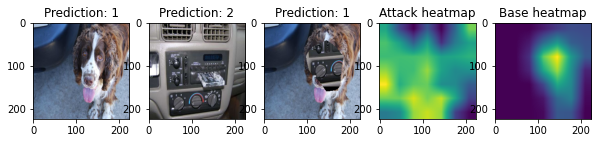

In [725]:
base_image = img_batch[0].cpu()
attack_image = img_batch[14].cpu()
adv, preds, (attack_hm, base_hm) = create_invariance_based_adversarial_example(base_image, attack_image, .85)

fix, axes = plt.subplots(1,5, figsize=(10,10))
axes = axes.flatten()
axes[0].imshow(base_image.permute(1,2,0))
axes[0].set_title('Prediction: '+str(preds[0].item()))
axes[1].imshow(attack_image.permute(1,2,0))
axes[1].set_title('Prediction: '+str(preds[1].item()))
axes[2].imshow(adv)
axes[2].set_title('Prediction: '+str(preds[2].item()))

axes[3].imshow(attack_hm.transpose(1,2,0))
axes[3].set_title('Attack heatmap')

axes[4].imshow(base_hm.transpose(1,2,0))
axes[4].set_title('Base heatmap')


In [44]:
base_image = img_batch[0].cpu()
attack_image = img_batch[14].cpu()
adv, preds = create_invariance_based_adversarial_example(base_image, attack_image, .85)

fix, axes = plt.subplots(1,3)
axes = axes.flatten()
axes[0].imshow(base_image.permute(1,2,0))
axes[0].set_title('Prediction: '+str(preds[0].item()))
axes[1].imshow(attack_image.permute(1,2,0))
axes[1].set_title('Prediction: '+str(preds[1].item()))
axes[2].imshow(adv)
axes[2].set_title('Prediction: '+str(preds[2].item()))


NameError: name 'create_invariance_based_adversarial_example' is not defined

### We might want to use a Gausian Filter on the Gradcam heatmaps for ensure rather large, coherent patches instead of fragments all over the image 

In [659]:

ndimage.gaussian_filter(attack_hm, 1)

array([[[0.54680896, 0.54680896, 0.54680896, ..., 0.16274513,
         0.16274513, 0.16274513],
        [0.54680896, 0.54680896, 0.54680896, ..., 0.16274513,
         0.16274513, 0.16274513],
        [0.54680896, 0.54680896, 0.54680896, ..., 0.16274513,
         0.16274513, 0.16274513],
        ...,
        [0.9875252 , 0.9875252 , 0.9875252 , ..., 0.2015774 ,
         0.2015774 , 0.2015774 ],
        [0.9875252 , 0.9875252 , 0.9875252 , ..., 0.2015774 ,
         0.2015774 , 0.2015774 ],
        [0.9875252 , 0.9875252 , 0.9875252 , ..., 0.2015774 ,
         0.2015774 , 0.2015774 ]]], dtype=float32)

Text(0.5, 1.0, 'sigma: 20')

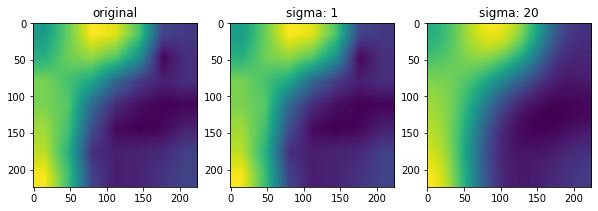

In [680]:
fix, axes = plt.subplots(1,3, figsize=(10,10))
axes = axes.flatten()
axes[0].imshow(attack_hm.transpose(1,2,0))
axes[0].set_title('original')
axes[1].imshow(ndimage.gaussian_filter(attack_hm, 1).transpose(1,2,0))
axes[1].set_title('sigma: 1')
axes[2].imshow(ndimage.gaussian_filter(attack_hm, 20).transpose(1,2,0))
axes[2].set_title('sigma: 20')


# Create and Save Heatmaps

In [61]:
PATH = Path('/home/florian/dev/ET-Adversarials/data/gradcam_heatmaps.pkl')

heatmaps = cam(input_tensor=img_batch)
heatmaps = torch.tensor(np.expand_dims(heatmaps,1))

torch.save(heatmaps, PATH)
